## Analyze US Consumption Habits
#### By Bhakti Patel

Description: The goal of this project is to conduct a preliminary study on consumer behavior in the US market for products sourced from a new origin. The analysis will explore how consumption varies with revenue and other drivers, investigate whether variations in consumption are primarily influenced by changes in one variable or multiple variables through hypothesis testing, examine if American residents adjust their consumption based on inflation, and finally, assess how the interaction between all variables and their impact on each other have evolved from 1929 to 2021. 

### Get to know the Data

- $Y$ : Consumption - in Billion USD
- $X$ : Revenue (Income) - in Billion USD
- $T$ : Trend (Time) - A sequence $[1,N]$ *Please don't include in plots, only for regression*
- $Z$ : Population - In capita
- $P$ : Consumer price index (Inflation)

Important note: The scales of the variables are very different.

### **Exploratory Data Analysis**

In [1]:
# Import necessary packages (You can use other ones with the same purpose)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm
from scipy.stats import shapiro

# import data
data = pd.read_excel('ConsumptionData.xlsx', index_col='Year')

In [2]:
data.head()

,Consumption (Billion USD),Revenue (Billion USD),Population,Price Index,Trend
Year,,,,,
1929,77.4,85.3,121767000,9.391,1
1930,70.1,76.5,123076741,9.028,2
1931,60.7,65.7,124039648,8.136,3
1932,48.7,50.3,124840471,7.209,4
1933,45.9,47.2,125578763,7.014,5


In [3]:
#check for missing values
data.isnull().sum()

Consumption (Billion USD)    0
Revenue  (Billion USD)       0
Population                   0
Price Index                  0
Trend                        0
dtype: int64

In [4]:
# Printing data overview
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 1929 to 2021
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Consumption (Billion USD)  93 non-null     float64
 1   Revenue  (Billion USD)     93 non-null     float64
 2   Population                 93 non-null     int64  
 3   Price Index                93 non-null     float64
 4   Trend                      93 non-null     int64  
dtypes: float64(3), int64(2)
memory usage: 4.4 KB


In [5]:
# summary stats
data.describe().round()

,Consumption (Billion USD),Revenue (Billion USD),Population,Price Index,Trend
count,93.0,93.0,93.0,93.0,93.0
mean,3559.0,4536.0,218552668.0,45.0,47.0
std,4472.0,5718.0,66336212.0,36.0,27.0
min,46.0,47.0,121767000.0,7.0,1.0
25%,219.0,282.0,157552740.0,14.0,24.0
50%,1030.0,1369.0,215973000.0,30.0,47.0
75%,5877.0,7607.0,275854000.0,75.0,70.0
max,15903.0,21295.0,331893745.0,119.0,93.0


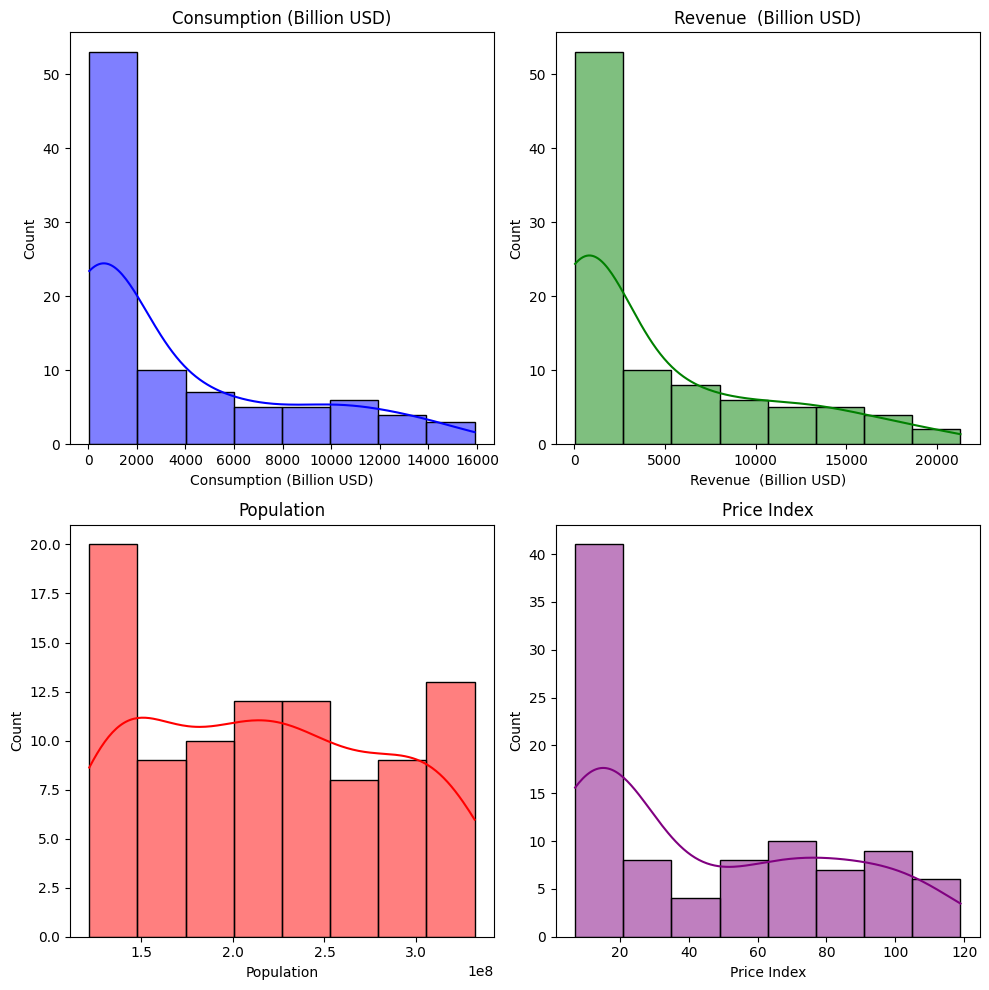

In [6]:
# Plotting distribution of all the variables

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Colors for each plot
colors = ['blue', 'green', 'red', 'purple']

axes = axes.flatten()

# Plot distribution of each variable
for ax, column, color in zip(axes, data.columns, colors):
    sns.histplot(data[column], color=color, kde=True, ax=ax)
    ax.set_title(column)

# Adjust the layout
plt.tight_layout()
plt.show()

- Consumption and Revenue show a right-skewed distribution, with a long tail to the right. This indicates that there are a few years with high consumption and revenue levels compared to most other years. The median consumption and revenue is less than the mean.
- Population shows a left-skewed(negative) distribution, indicating steady population growth over time, with most years having a higher population than the previous years. The median population is greater than the mean population in this case.
- Price Index also shows a right-skewed distribution, indicating that there are some periods of higher inflation. The median price index is less than the mean price index.

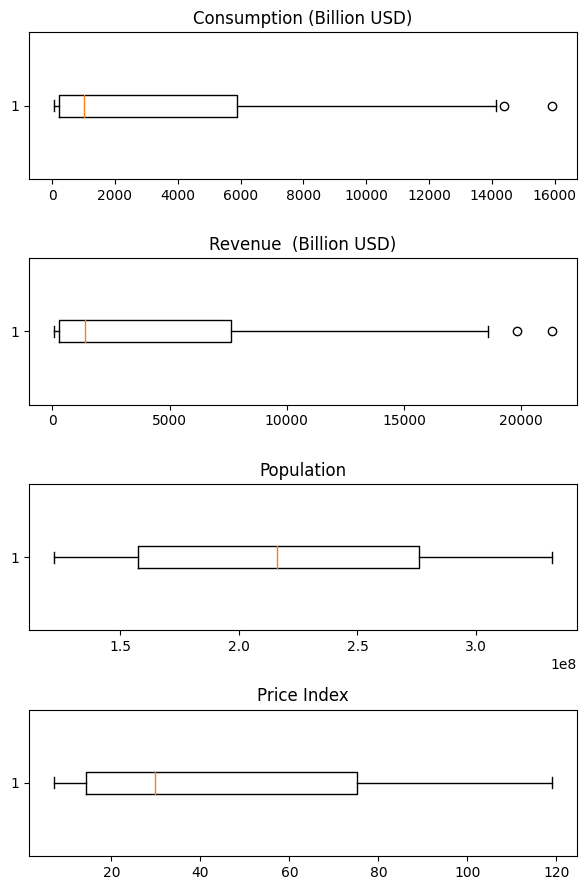

In [15]:
# Create boxplots to find outliers
# Exclude the "Trend" column
data_no_trend = data.drop(columns=["Trend"])

# Create a figure and axes
fig, axs = plt.subplots(nrows=len(data_no_trend.columns), figsize=(6, 9))

# Create horizontal boxplots for each variable
for ax, column in zip(axs, data_no_trend.columns):
    ax.boxplot(data_no_trend[column], vert=False)  # Add vert=False to make the boxplots horizontal
    ax.set_title(column)

# Improve layout
plt.tight_layout()
plt.show()

Consumption and Revenue have a few outliers

In [16]:
# identify outliers based on the IQR method
def find_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

# Find outliers in Consumption and Revenue
consumption_outliers = find_outliers_iqr(data["Consumption (Billion USD)"])
revenue_outliers = find_outliers_iqr(data["Revenue  (Billion USD)"])

consumption_outliers, revenue_outliers

(Year
 2019    14392.7
 2021    15902.6
 Name: Consumption (Billion USD), dtype: float64,
 Year
 2020    19832.3
 2021    21294.8
 Name: Revenue  (Billion USD), dtype: float64)

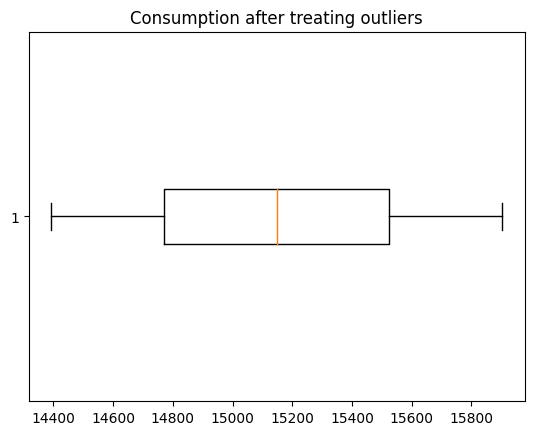

In [18]:
plt.boxplot(consumption_outliers,vert=False)
plt.title("Consumption after treating outliers");

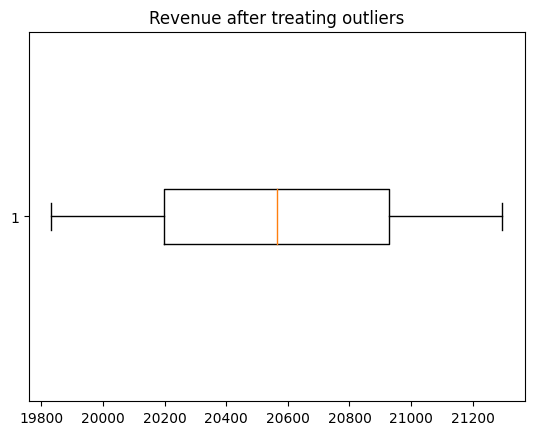

In [19]:
plt.boxplot(revenue_outliers,vert=False)
plt.title("Revenue after treating outliers");

I'll keep the outliers since they seem to be due to a historic event(covid) which had impact on economic growth.

### **Descriptive Analysis**

#### Calculate yearly percentage change

In [20]:
# Calculate yearly percentage change by using the pct_change function
data['Consumption_chg'] = data['Consumption (Billion USD)'].pct_change() * 100
data['Revenue_chg'] = data['Revenue  (Billion USD)'].pct_change() * 100
data['Population_chg'] = data['Population'].pct_change() * 100
data['Price_Index_chg'] = data['Price Index'].pct_change() * 100

In [21]:
data.head()

,Consumption (Billion USD),Revenue (Billion USD),Population,Price Index,Trend,Consumption_chg,Revenue_chg,Population_chg,Price_Index_chg
Year,,,,,,,,,
1929,77.4,85.3,121767000,9.391,1,NaN,NaN,NaN,NaN
1930,70.1,76.5,123076741,9.028,2,-9.431525,-10.316530,1.075612,-3.865403
1931,60.7,65.7,124039648,8.136,3,-13.409415,-14.117647,0.782363,-9.880372
1932,48.7,50.3,124840471,7.209,4,-19.769357,-23.439878,0.645619,-11.393805
1933,45.9,47.2,125578763,7.014,5,-5.749487,-6.163022,0.591388,-2.704952


#### Plot the percentage variation in each year for all variables and compare

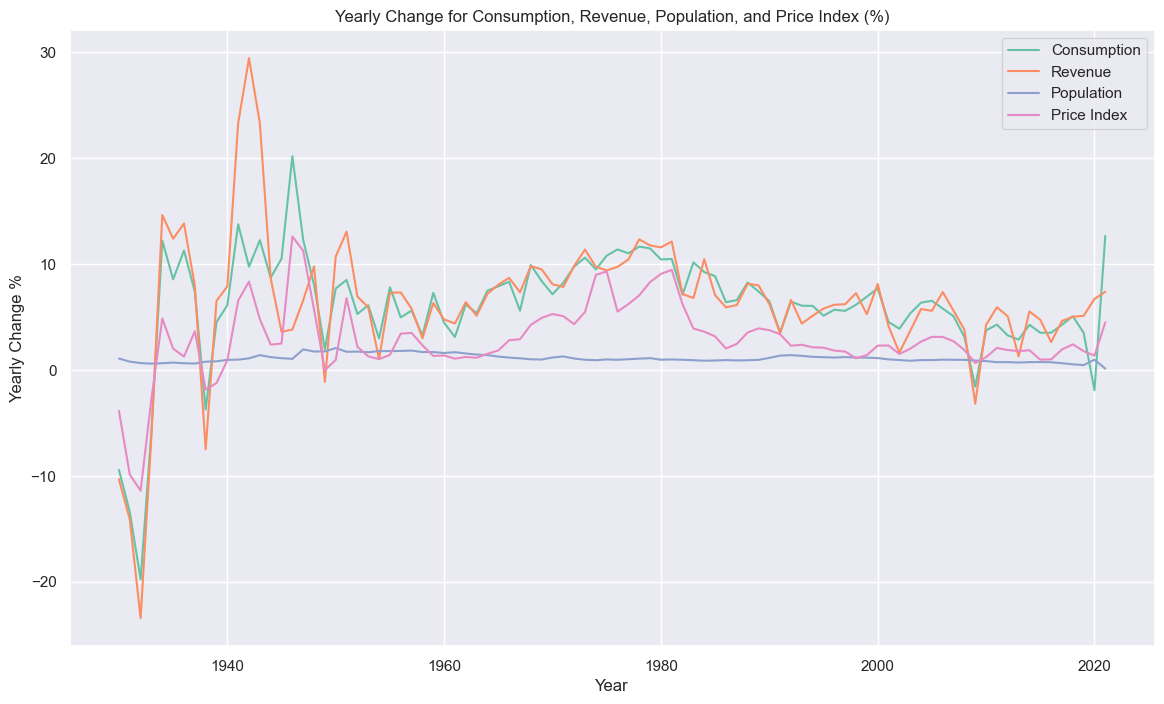

In [22]:
# set color palette 
sns.set(style='darkgrid', palette='Set2')

# Plot the yearly percentage changes
plt.figure(figsize=(14, 8))

sns.lineplot(data=data['Consumption_chg'], label='Consumption')
sns.lineplot(data=data['Revenue_chg'], label='Revenue')
sns.lineplot(data=data['Population_chg'], label='Population')
sns.lineplot(data=data['Price_Index_chg'], label='Price Index')

plt.xlabel('Year')
plt.ylabel('Yearly Change %')
plt.title('Yearly Change for Consumption, Revenue, Population, and Price Index (%)')
plt.legend()
plt.show()

- In this plot, we can see there are fluctuations in the percentage change of Consumption with several peaks and troughs indicating periods of rapid change. There were significant drops around early 1930s (the Great Depression), the mid-1940s (World War II), the late 2000s (the 2008 financial crisis), and around 2020 (the COVID-19 pandemic)
- Revenue generally increased over time, like Consumption, with similar periods of decline. 
- The Population shows a relatively steady increase over time, with a slight decrease in the rate of growth in recent years(likely due to Covid-19).
- The Price Index shows a steady increase over time, with some periods of rapid inflation. There was a noticeable increase from the 1970s to early 1980s, possibly due to various economic factors such as the end of the Bretton Woods system and oil crises.

#### Calculate the percentage of revenue dedicated to consumption

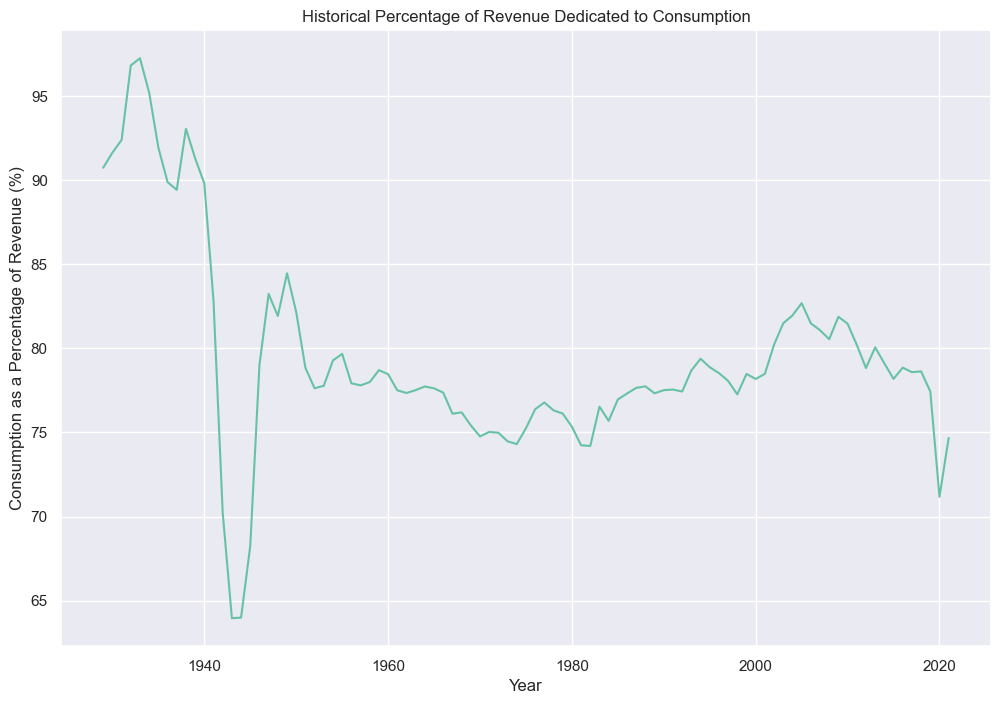

In [24]:
# Percentage of revenue dedicated to consumption
data['consumption_revenue_pct'] = (data['Consumption (Billion USD)'] / data['Revenue  (Billion USD)']) * 100

# Plot 
plt.figure(figsize=(12,8))

plt.plot(data.index, data['consumption_revenue_pct'])

plt.xlabel('Year')
plt.ylabel('Consumption as a Percentage of Revenue (%)')
plt.title('Historical Percentage of Revenue Dedicated to Consumption')
plt.grid(True)
plt.show()

- There is an increase in the percentage of revenue dedicated to consumption during the Great Depression (1929 - 1933). This could be due to the economic hardship faced during this period, forcing people to consume a larger portion of their income.
- From the mid-1930s to the early 1980s, the percentage of revenue dedicated to consumption generally decreases or remains stable. This could be attributed to economic growth and increased prosperity, allowing people to save a larger portion of their income.
- From the early 1980s onwards, there is a slight increase, which could be due to the economy improving.
- Notably, during the financial crisis of 2008 and the COVID-19 pandemic, there are visible spikes. These could be due to people consuming a larger portion of their revenue during these periods of uncertainty.

#### What years were consumption close to taking 100% of revenue? Is it due to Inflation?

In [30]:
# Identify the years where consumption was close to taking 100% of revenue
high_consumption_years = data[data['consumption_revenue_pct'] >= 96].index.values

# Display the years and corresponding Price Index values
high_consumption = data[data.index.isin(high_consumption_years)][['Price Index', 'consumption_revenue_pct']]
high_consumption

,Price Index,consumption_revenue_pct
Year,,
1932,7.209,96.819085
1933,7.014,97.245763


The years where consumption was close to 100% of revenue are 1932 and 1933(correspond to the period of the Great Depression).

During these years, the Price Index (measure of inflation) was 7.209 and 7.014, respectively. The high percentage of consumption relative to revenue during these years may not be directly due to inflation, as the Price Index is not particularly high during these years compared to other periods. Instead, it's likely due to the economic hardship of the Great Depression, where people may have had to spend a larger proportion of their income on basic necessities, therefore leaving less money for savings or investment.

#### Analyze distribution of Consumption as a % of Revenue

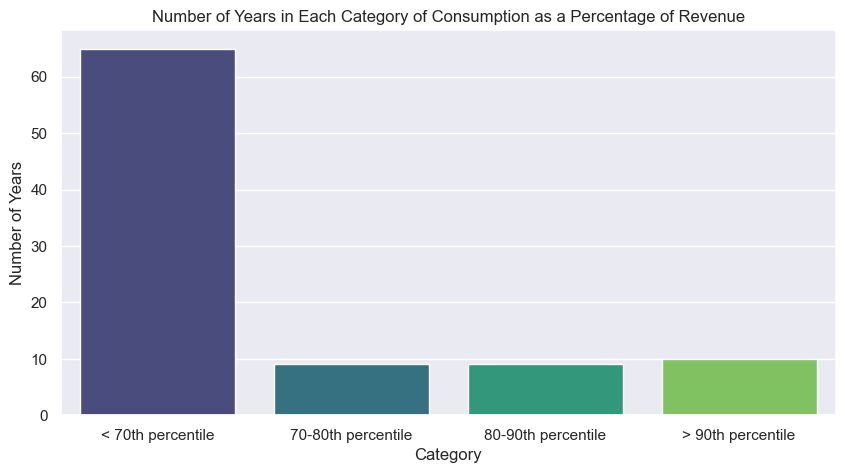

In [ ]:
# Calculate the 70th, 80th and 90th percentiles of the distribution
percentiles = data['consumption_revenue_pct'].quantile([0.7, 0.8, 0.9]).to_list()

# Define the categories based on the percentiles
categories = ["< 70th percentile", "70-80th percentile", "80-90th percentile", "> 90th percentile"]

# Initialize a dictionary to store the number of years in each category
years_in_categories = dict.fromkeys(categories, 0)

# Count the number of years in each category
for year, pct in data['consumption_revenue_pct'].items():
    if pct < percentiles[0]:
        years_in_categories["< 70th percentile"] += 1
    elif pct < percentiles[1]:
        years_in_categories["70-80th percentile"] += 1
    elif pct < percentiles[2]:
        years_in_categories["80-90th percentile"] += 1
    else:
        years_in_categories["> 90th percentile"] += 1

# Convert the dictionary to a DataFrame for plotting
df_years_in_categories = pd.DataFrame(list(years_in_categories.items()), columns=['Category', 'Number of Years'])

# Plot the number of years in each category
plt.figure(figsize=(10, 5))
sns.barplot(data=df_years_in_categories, x='Category', y='Number of Years', palette='viridis')
plt.title("Number of Years in Each Category of Consumption as a Percentage of Revenue")
plt.show()

In [33]:
# Calculate the 70th, 80th and 90th percentiles of the distribution
percentiles = data['consumption_revenue_pct'].quantile([0.7, 0.8, 0.9]).to_list()

# Define the categories based on the percentiles
categories = ["< 70th percentile", "70-80th percentile", "80-90th percentile", "> 90th percentile"]

# Initialize a dictionary to store the years in each category
years_in_categories = {category: [] for category in categories}

# Identify the years in each category
for year, pct in data['consumption_revenue_pct'].items():
    if pct < percentiles[0]:
        years_in_categories["< 70th percentile"].append(year)
    elif pct < percentiles[1]:
        years_in_categories["70-80th percentile"].append(year)
    elif pct < percentiles[2]:
        years_in_categories["80-90th percentile"].append(year)
    else:
        years_in_categories["> 90th percentile"].append(year)

# # Display the years in each category
# print(years_in_categories["70-80th percentile"])
# print(years_in_categories["80-90th percentile"])
for category, years in years_in_categories.items():
    if category != "< 70th percentile":
        print(f"{category}: {', '.join(map(str, years))}")

70-80th percentile: 2002, 2003, 2006, 2007, 2008, 2009, 2010, 2011, 2013
80-90th percentile: 1937, 1940, 1941, 1947, 1948, 1949, 1950, 2004, 2005
> 90th percentile: 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1938, 1939


- **70-80th percentile (2002, 2003, 2006, 2007, 2008, 2009, 2010, 2011, 2013)**: These years span the period leading up to, during, and post the Global Financial Crisis of 2007-2008. 
    - In the lead-up to the crisis (2002-2007), the economy was characterized by high consumer confidence and spending, which would contribute to a high consumption as a percentage of revenue. 
    - During the financial crisis (2008-2013), many people and businesses would have reduced their savings and investment due to economic uncertainty and financial hardship, which could also have led to a higher consumption as a percentage of revenue.

- **80-90th percentile (1937, 1940, 1941, 1947, 1948, 1949, 1950, 2004, 2005)**: This category includes years during the end of the Great Depression, World War II, and the post-war period, as well as the mid-2000s before the Global Financial Crisis. 
    - In the 1930s and 1940s, economic volatility and wartime spending likely led to high consumption as a percentage of revenue. 
    - In the mid-2000s, as with the 70-80th percentile years, high consumer confidence and spending would have contributed to high consumption as a percentage of revenue.

- **> 90th percentile (1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1938, 1939)**: These years coincide with the Great Depression. 
    - During this time, consumption as a percentage of revenue would have been high due to a combination of lower overall revenue (depressed economy) and higher relative consumption as people spent a larger portion of their income on essentials. Investment would have been very low during this time due to economic uncertainty and financial hardship.

In [34]:
#drop the extra columns
columns_to_remove = ['Consumption_chg', 'Revenue_chg','Population_chg','Price_Index_chg','consumption_revenue_pct']
data = data.drop(columns=columns_to_remove)
data.head()

,Consumption (Billion USD),Revenue (Billion USD),Population,Price Index,Trend
Year,,,,,
1929,77.4,85.3,121767000,9.391,1
1930,70.1,76.5,123076741,9.028,2
1931,60.7,65.7,124039648,8.136,3
1932,48.7,50.3,124840471,7.209,4
1933,45.9,47.2,125578763,7.014,5


#### Correlation Matrix

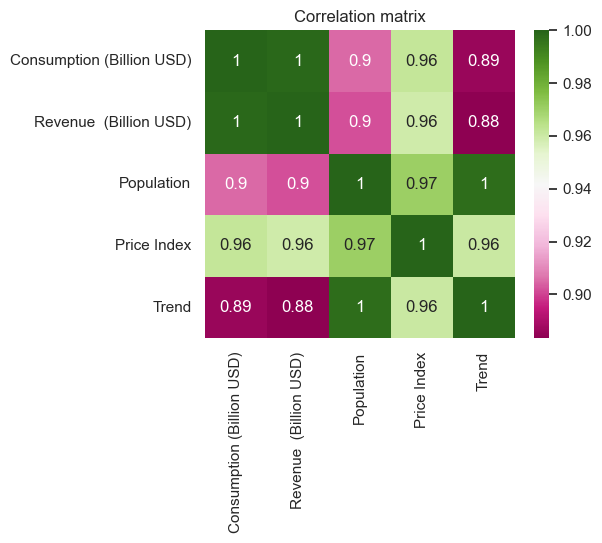

In [35]:
# How strong is the relationship between the variables and in what sense?
correlation_matrix = data.corr()

# Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(correlation_matrix, annot=True, cmap='PiYG')
plt.title('Correlation matrix')
plt.show()

Based on the correlation matrix, we can see that all the variables have a strong positive correlation with each other:

- Consumption and Revenue(1.0): as revenue increases, consumption increases, and vice versa.
- Consumption and Population(0.9): as the population grows, consumption tends to increase.
- Consumption and Price Index(0.96): consumption tends to rise with an increase in the price index(can be associated with inflation)
- Population and Revenue(0.9): as population increases, revenue also tends to increase.
- Price Index with Revenue(0.96) and Population(0.97): these variables tend to rise with an increase in the price index.

### **Periodic analysis**

In [36]:
# Are the trends of the variables consistent between 1929 and 2021 ? Are there periods that stand out ?
# How do variables behave during the period of the 2008 crisis ?
# How do variables behave during the Covid period ?
# Are there any periods characterized by a non homogenous behavior ? If yes please provide a historical explanation.

#### Are the trends of the variables consistent between 1929 and 2021? Are there periods that stand out?

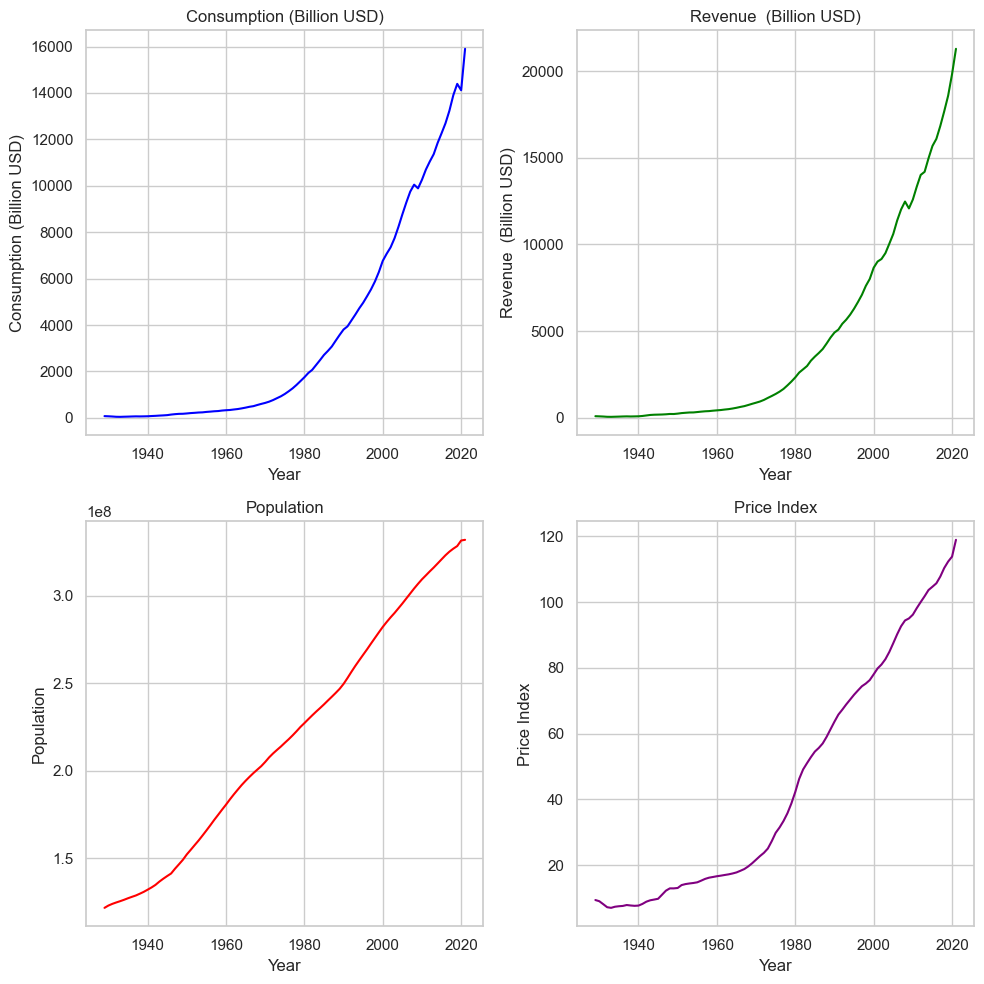

In [37]:
# Setting the style of seaborn plot
sns.set(style="whitegrid")

# Create a new figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

colors = ['blue', 'green', 'red', 'purple']

# Flatten the axes array
axes = axes.flatten()

# Plot each variable
for ax, column, color in zip(axes, data.columns, colors):
    sns.lineplot(data=data, x=data.index, y=column, color=color, ax=ax)
    ax.set_title(column)

# Adjust the layout
plt.tight_layout()

plt.show()

- Consumption has consistently increased over time, suggesting economic growth. There are some periods of slowed growth or slight contraction (like the drop in consumption and revenue during the Global Financial Crisis and Covid). The economic growth is not always linear but seems to be quite consistent over the long term.

- Revenue is not linear, but has been consistently increasing over time. It dropped a little during the 2008 financial crisis.

- Population has been consistently increasing over time. The growth is relatively linear, and no major population drop or surge.

- Price Index has generally been increasing over time, suggesting consistent inflation. This is typical for most economies over the long term. The rate of increase in the price index appears to accelerate somewhat from the 1970s onwards, possibly due to the high inflation period caused by post WWII boom due to increased government spending and economic mobilization.

#### How do variables behave during the period of the 2008 crisis?

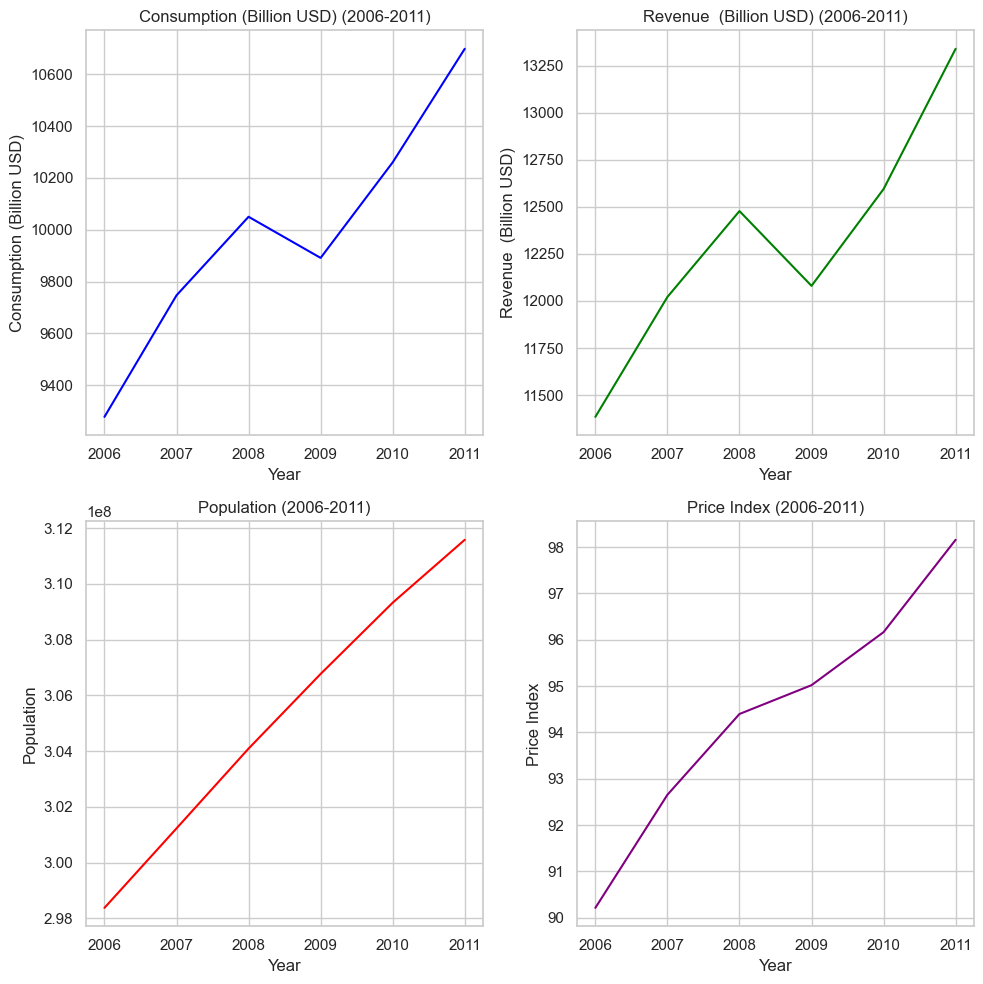

In [38]:
# Define the period of the 2008 crisis
start_year = 2006
end_year = 2011

# Filter data for the 2008 crisis period
crisis_data = data.loc[start_year:end_year]

# Create a new figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

colors = ['blue', 'green', 'red', 'purple']

# Flatten the axes array
axes = axes.flatten()

# Plot each variable
for ax, column,color in zip(axes, crisis_data.columns, colors):
    sns.lineplot(data=crisis_data, x=crisis_data.index, y=column,color=color, ax=ax)
    ax.set_title(f"{column} (2006-2011)")

# Adjust the layout
plt.tight_layout()

plt.show()

- Consumption and Revenue both show a significant drop in 2008, reflecting the impact of the financial crisis. This is reflective of the economic downturn, where people typically cut back on spending due to uncertainties and income reductions. They begin to recover in 2009 and 2010.

- Population (Red) continues to increase during this period.

- Price Index increased from 92.653 in 2007 to 94.397 in 2008, reflecting inflation. However, the rate of increase slowed significantly in 2009, with the Price Index only increasing to 95.019. This slowdown in inflation may reflect the decreased demand and economic activity during the crisis.

#### How do variables behave during the Covid period?

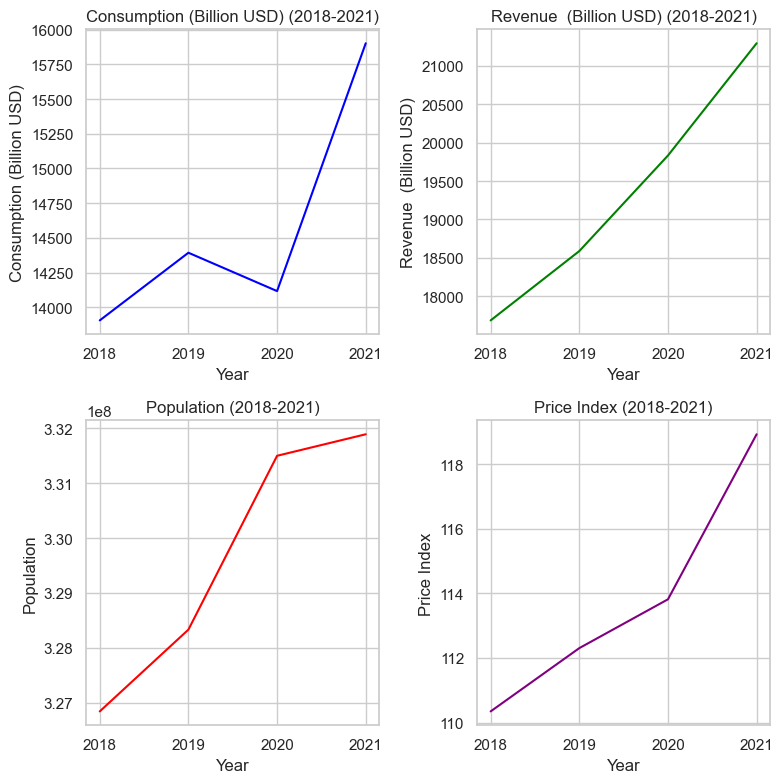

In [39]:
# Define the period of the Covid-19 pandemic
start_year = 2018
end_year = 2021

# Filter data for the Covid-19 pandemic period
covid_data = data.loc[start_year:end_year]

# Create a new figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

colors = ['blue', 'green', 'red', 'purple']

# Flatten the axes array
axes = axes.flatten()

# Plot each variable
for ax, column, color in zip(axes, covid_data.columns, colors):
    sns.lineplot(data=covid_data, x=covid_data.index, y=column, color=color, ax=ax)
    ax.set_title(f"{column} (2018-2021)")

# Adjust the layout
plt.tight_layout()

plt.show()

- Consumption dropped between 2019 to 2020 during covid. This decrease reflects the impact of the pandemic restrictions, business closures, and uncertainty which led to decreased consumer spending.

- Despite the drop in Consumption, Revenue actually increased during this period which could be due to a variety of factors including borrowing and govt aid.

- Population shows an increase during this period.   

- Price Index also shows an increase, reflecting inflation during this period, although the rate was lower than in some previous years.

#### Are there any periods characterized by a non homogenous behavior? If yes, please provide a historical explanation.  

Based on the data, there are several periods where there appears to be non-homogenous behavior in the variables:

1. **Great Depression (1929-1933):** The data shows significant drops in both Consumption and Revenue during this period. This was a severe worldwide economic depression, triggered by the stock market crash in 1929, and marked by decreases in consumer spending and business investment.

2. **World War II (1939-1945):** There are noticeable spikes in both Consumption and Revenue during these years, likely due to increased military spending, mobilization of workforce and an uptick in manufacturing to support the war effort.

3. **Post-War Boom (1945-1970):** In the years following WWII, there was a significant increase in Consumption, Revenue, and the Price Index. This period is known as the post-war economic boom or the "Golden Age of Capitalism" and was characterized by high growth, low unemployment, and high rates of productivity growth.

4. **Stagflation (1970s):** During the 1970s, there was continued increase in Consumption and Revenue, but the Price Index grew at a much faster rate. This period was marked by stagflation - a situation where the inflation rate is high, the economic growth rate slows, and unemployment remains steadily high. The 1973 oil crisis could be one of the triggers for this period.

5. **Financial Crisis (2008-2009):** The data shows a drop in Consumption and Revenue in 2008 and a slight recovery in 2009. This period was marked by the Great Recession, triggered by the subprime mortgage crisis in the US, which led to a global economic downturn.

6. **COVID-19 Pandemic (2019-2021):** The recent decrease in Consumption in 2020 is likely due to the impacts of the COVID-19 pandemic. Despite the drop in Consumption, Revenue increased, likely due to government fiscal response to the crisis.

Each of these periods shows a deviation from the general trend, and each is associated with significant historical events or conditions that would be expected to impact economic factors like consumption and revenue.

#### Plot scatter plots for Consumption against Year, Revenue, Population, and Price Index

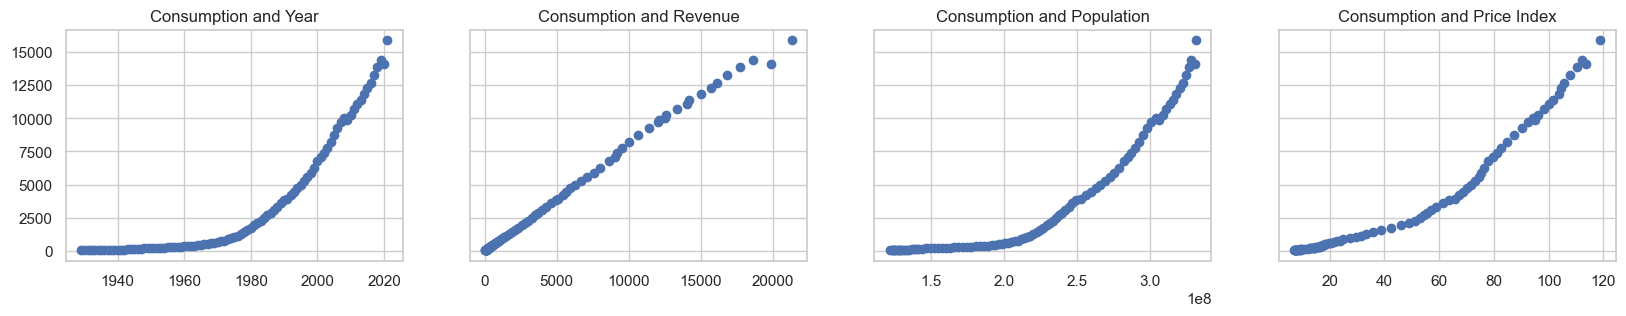

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize =(20,3)) # sharey -> share 'Consumption (Billion USD)' as y
ax1.scatter(data.index, data['Consumption (Billion USD)'])
ax1.set_title('Consumption and Year')
ax2.scatter(data['Revenue  (Billion USD)'], data['Consumption (Billion USD)'])
ax2.set_title('Consumption and Revenue')
ax3.scatter(data['Population'], data['Consumption (Billion USD)'])
ax3.set_title('Consumption and Population')
ax4.scatter(data['Price Index'], data['Consumption (Billion USD)'])
ax4.set_title('Consumption and Price Index')

plt.show()

## **Linear regression and hypothesis testing**

$Y_t$ = $\beta_0 + \beta_1 X_t + \beta_2 T_t + \beta_3 Z_t + \beta_4 P_t$

#### **Run a linear regression to estimate Consumption using other variables.**

Before running the linear regression, my hypothesis is:

- As Revenue increases, Consumption will likely increase as people have more disposable income to spend.
- As Population increases, Consumption might increase due to a larger number of consumers.
- The Trend variable might capture some long-term changes in Consumption that aren't accounted for by the other variables.
- The effect of Price Index might be negative on Consumption, as an increase in prices (inflation) may lead to less consumption due to reduced purchasing power. 

#### Regression Model

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Separate the dependent and independent variables
y = data['Consumption (Billion USD)']
X = data[['Revenue  (Billion USD)', 'Trend', 'Population', 'Price Index']]

# Standardize the variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add a constant to the independent variables matrix
X_scaled = sm.add_constant(X_scaled)

# Create and fit the model
model = sm.OLS(y, X_scaled)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Consumption (Billion USD)   R-squared:                       0.998
Model:                                   OLS   Adj. R-squared:                  0.998
Method:                        Least Squares   F-statistic:                 1.273e+04
Date:                       Fri, 14 Jul 2023   Prob (F-statistic):          1.17e-120
Time:                               19:49:25   Log-Likelihood:                -617.32
No. Observations:                         93   AIC:                             1245.
Df Residuals:                             88   BIC:                             1257.
Df Model:                                  4                                         
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3558.6484     19.692    180.718      0.000    3519.515    3597.781
x1          4111.5167     81.169     50.654      0.000    3950.210    4272.823
x2         -1110.2725    321.370     -3.455      0.001   -1748.928    -471.617
x3          1106.2506    358.717      3.084      0.003     393.375    1819.126
x4           328.0412    137.440      2.387      0.019      54.909     601.173
==============================================================================
Omnibus:                       81.231   Durbin-Watson:                   0.699
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1032.324
Skew:                          -2.532   Prob(JB):                    6.82e-225
Kurtosis:                      18.516   Cond. No.                         47.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Analyzing the table: 
- R-squared value is 0.998, which suggests that the model explains 99.8% of the variance in Consumption, indicating a very good fit to the data.
    - The adjusted R-squared is also 0.998 and this value being close to the R-squared value indicates that all our predictors are useful.
- The F-statistic is large and the associated p-value is very small, indicating that the model is statistically significant.
- The p-values for all coefficients are less than 0.05, which means all variables are statistically significant in predicting Consumption. 

In [49]:
from sklearn.model_selection import train_test_split

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [50]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [51]:
#predicting the test set results
y_pred = regressor.predict(X_test)
y_pred

array([  606.54493561,    70.1610303 ,  2683.42572706,  7199.84886152,
         364.66970955,   149.40731075,   556.69366938,  5406.00713226,
         -17.90293277,   888.37648982, 11003.24201011,   410.87783287,
       14300.83017497,  4103.13140931,   -47.95306593,   170.21495622,
         -20.25246389,   218.61888861,  1496.30899347,  4827.74411816,
         -34.86412295,  5730.1963134 ,  9505.7530447 ,   270.96450002,
         354.14578949,   -40.62515998,  5103.36512492,  6117.23601631])

In [52]:
#calculating the coefficients
print(regressor.coef_)

[    0.          3981.83554462 -1494.69533033  1486.40840861
   462.08854409]


In [53]:
#calculating the intercept
print(regressor.intercept_)

3563.4738311106153


In [54]:
#calculating the r-squared value
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9986902261597902

The high R² suggests that the model performs well on the test set as seen previously in the OLS table.

---


**Hypothesis Testing through models**
- Model 1 : $Y_t$ = $\beta_0$
- Model 2 : $Y_t$ = $\beta_0 + \beta_1 X_t$
- Model 3 : $Y_t$ = $\beta_0 + \beta_1 X_t + \beta_2 T_t$
- Model 4 : $Y_t$ = $\beta_0 + \beta_1 X_t + \beta_2 T_t + \beta_3 Z_t$
- Model 5 : $Y_t$ = $\beta_0 + \beta_1 X_t + \beta_2 T_t + \beta_3 Z_t + \beta_4 P_t$


Test each model against the one that preceeds it. To do that run a fisher test that includes the number of restrctions (how many parameters (betas) did you remove relative to the non restricted model). <br>

$F_(constraint) = \frac{R^2_(non-restricted) - R^2_(restricted)}{number-of-restrictions} * \frac{N - K_(non-restricted) - 1}{1-R^2_(non-restricted)}$ <br>

With $K$ the number of parameters and $N$ the number of observations.


In [58]:
# Define the dependent variable and the independent variables
Y = data['Consumption (Billion USD)']
X = data[['Revenue  (Billion USD)', 'Trend', 'Population', 'Price Index']]

# Add a constant to the independent variables matrix
X = sm.add_constant(X)

# Run the OLS model
model = sm.OLS(Y, X)
results = model.fit()

results.summary()

# Define the models
model_1 = sm.OLS(Y, sm.add_constant(np.ones(len(Y))))
model_2 = sm.OLS(Y, sm.add_constant(data['Revenue  (Billion USD)']))
model_3 = sm.OLS(Y, sm.add_constant(data[['Revenue  (Billion USD)', 'Trend']]))
model_4 = sm.OLS(Y, sm.add_constant(data[['Revenue  (Billion USD)', 'Trend', 'Population']]))
model_5 = sm.OLS(Y, sm.add_constant(data[['Revenue  (Billion USD)', 'Trend', 'Population', 'Price Index']]))

# Fit the models
results_1 = model_1.fit()
results_2 = model_2.fit()
results_3 = model_3.fit()
results_4 = model_4.fit()
results_5 = model_5.fit()

# Conduct Fisher test for each pair of models
anova_results_1_2 = anova_lm(results_1, results_2)
anova_results_2_3 = anova_lm(results_2, results_3)
anova_results_3_4 = anova_lm(results_3, results_4)
anova_results_4_5 = anova_lm(results_4, results_5)

anova_results_1_2, anova_results_2_3, anova_results_3_4, anova_results_4_5

(   df_resid           ssr  df_diff       ss_diff             F         Pr(>F)
 0      92.0  1.839821e+09      0.0           NaN           NaN            NaN
 1      91.0  3.988307e+06      1.0  1.835832e+09  41887.633364  5.131960e-123,
    df_resid           ssr  df_diff        ss_diff         F    Pr(>F)
 0      91.0  3.988307e+06      0.0            NaN       NaN       NaN
 1      90.0  3.887933e+06      1.0  100373.577436  2.323502  0.130939,
    df_resid           ssr  df_diff        ss_diff          F    Pr(>F)
 0      90.0  3.887933e+06      0.0            NaN        NaN       NaN
 1      89.0  3.378882e+06      1.0  509051.481227  13.408454  0.000425,
    df_resid           ssr  df_diff        ss_diff         F    Pr(>F)
 0      89.0  3.378882e+06      0.0            NaN       NaN       NaN
 1      88.0  3.173444e+06      1.0  205438.332396  5.696831  0.019137)

The Fisher tests provide the following results:

- Model 1 vs Model 2 (adding Revenue):
    F statistic: 41887.633364
    p-value: < 0.001

- Model 2 vs Model 3 (adding Trend):
    F statistic: 2.323502
    p-value: 0.130939
    
- Model 3 vs Model 4 (adding Population):
    F statistic: 13.408454
    p-value: < 0.001

- Model 4 vs Model 5 (adding Price Index):
    F statistic: 5.696831
    p-value: 0.019137

From these results, we can conclude that adding all the variables to the Model 1 significantly improves the models (p-values < 0.05). 

I will use Model 5 for these checks, as it includes all variables and performed significantly better than Model 4 according to the Fisher test.

</br>
---------

**OLS Hypothesis Testing**
- Normality of residuals
- Homoscedasticity
- Serial autocorrelation
- Multicollinearity

Choose the best Model from the 5 mentioned above and check the OLS conditions <br>

#### Normality of residuals

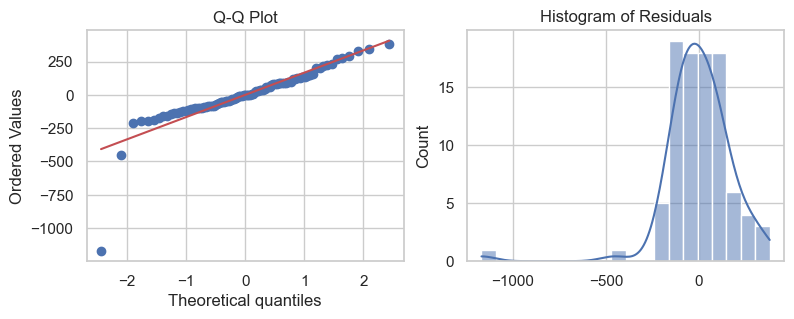

Shapiro-Wilk test statistic: 0.8029143810272217, p-value: 8.20119083755344e-10


In [59]:
# Calculate residuals for the fitted model
residuals = results.resid

# Normality of residuals
# Q-Q plot
plt.figure(figsize=(9, 3))
plt.subplot(121)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')

# Histogram
plt.subplot(122)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

# Shapiro-Wilk test
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk test statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")

Normality of residuals: The p-value of the Shapiro-Wilk test is less than 0.05, which suggests that the residuals are not normally distributed. The Q-Q plot and the histogram of residuals also indicate some deviation from normality, particularly with some skewness and heavy tails.

**To address the normality of residuals issue, I'll apply log transformation**

In [66]:
# Apply log transformation to the dependent variable
Y_log = np.log(Y)

# Define the new model excluding 'Trend'
model_6 = sm.OLS(Y_log, sm.add_constant(data[['Revenue  (Billion USD)', 'Population', 'Price Index']]))

# Fit the model
results_6 = model_6.fit()

# Get the residuals
residuals_6 = results_6.resid

# Shapiro-Wilk test
shapiro_test = stats.shapiro(residuals_6)
print(f"Shapiro-Wilk test statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")

Shapiro-Wilk test statistic: 0.9850850701332092, p-value: 0.37201982736587524


Normality of residuals: The Shapiro-Wilk test resulted in a p-value greater than 0.05, indicating that the residuals are now normally distributed.

#### No homoscedasticity

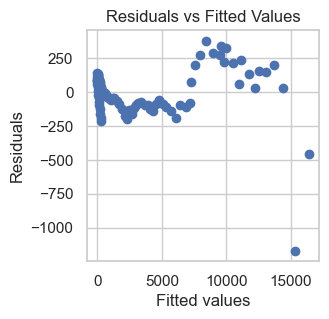

Breusch-Pagan test statistic: 21.012330087156133, p-value: 0.00031489161393074


In [43]:
# Homoscedasticity
# Residuals vs Predicted values plot
from statsmodels.stats.diagnostic import het_breuschpagan

plt.figure(figsize=(3, 3))
plt.scatter(results.fittedvalues, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Breusch-Pagan test
bp_test = het_breuschpagan(residuals, results.model.exog)
print(f"Breusch-Pagan test statistic: {bp_test[0]}, p-value: {bp_test[1]}")

Homoscedasticity: The p-value of the Breusch-Pagan test is less than 0.05, which indicates that the variance of the residuals is not constant across levels of the independent variables (heteroscedasticity).

In [67]:
# Apply a log transformation to the dependent variable
Y_log = np.log(Y)

# Define the new model excluding 'Trend'
model_6 = sm.OLS(Y_log, sm.add_constant(data[['Revenue  (Billion USD)', 'Population', 'Price Index']]))

# Fit the model
results_6 = model_6.fit()

# Get the residuals
residuals_6 = results_6.resid

bp_test = het_breuschpagan(residuals_6, results.model.exog)
print(f"Breusch-Pagan test statistic: {bp_test[0]}, p-value: {bp_test[1]}")

Breusch-Pagan test statistic: 32.71189353051451, p-value: 1.368204085546373e-06


Homoscedasticity: Even after the log transformation, p-value is less than 0.05 indicating residuals are still heteroscedastic.

#### No autocorrelation

In [68]:
# Autocorrelation
# Durbin-Watson statistic
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat}")

Durbin-Watson statistic: 0.6994668426264665


No autocorrelation: The Durbin-Watson statistic is around 0.70, which is less than the typical threshold of 2. This suggests that there is positive autocorrelation in the residuals.

**I'll run the ARIMA time series model to treat autocorrelation in residuals**

C:\Users\bhakt\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


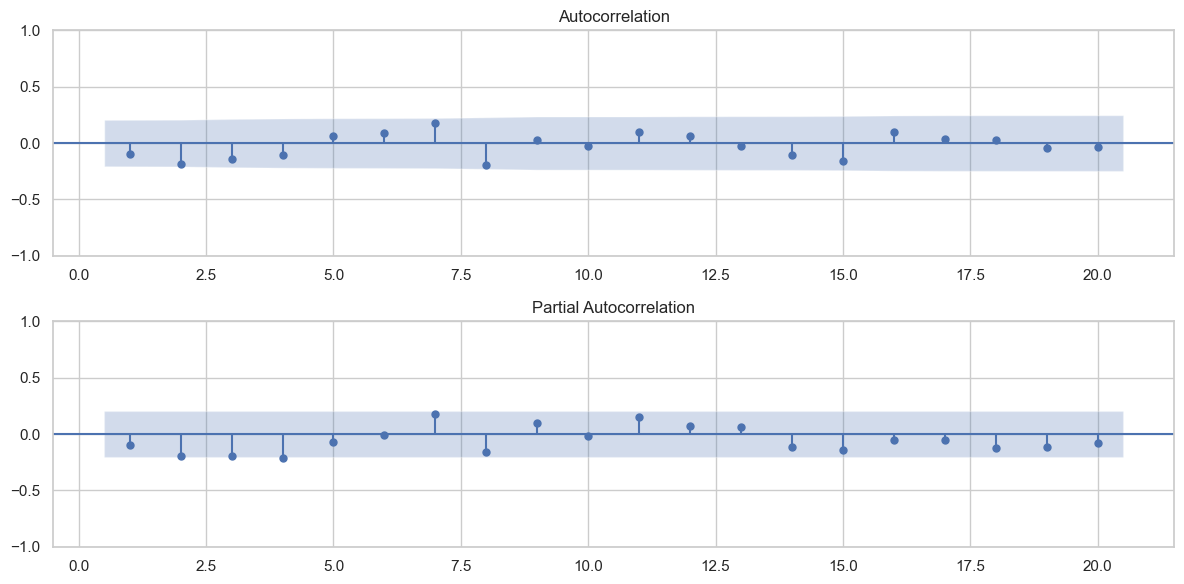

In [69]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate twice-differenced log-transformed Consumption data
Y_log_diff2 = Y_log.diff().diff().dropna()

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

plot_acf(Y_log_diff2, lags=20, zero=False, ax=ax[0])
plot_pacf(Y_log_diff2, lags=20, zero=False, ax=ax[1])

plt.tight_layout()
plt.show()

In [70]:
from statsmodels.tsa.arima.model import ARIMA

# Define the model
model_arima = ARIMA(Y_log, order=(1, 2, 1))

# Fit the model
results_arima = model_arima.fit()

results_arima.summary()

C:\Users\bhakt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bhakt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bhakt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     Consumption (Billion USD)   No. Observations:                   93
Model:                        ARIMA(1, 2, 1)   Log Likelihood                 163.871
Date:                       Fri, 14 Jul 2023   AIC                           -321.743
Time:                               21:52:02   BIC                           -314.210
Sample:                                    0   HQIC                          -318.704
                                        - 93                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7275      0.075      9.654      0.000       0.580       0.875
ma.L1         -0.9949      0.376     -2.644      0.008      -1.732      -0.257
sigma2         0.0016      0.001      2.779      0.005       0.000       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               121.07
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                             1.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Coefficient of the autoregressive term (ar.L1): 0.7275 
- Coefficient of the moving average term (ma.L1): -0.9949 

***The p-values for both coefficients are less than 0.05, which means both are statistically significant.***

#### Multicollinearity

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = data[['Revenue  (Billion USD)','Population','Price Index', 'Trend']]

# we create a new data frame which will include all the VIFs
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

,VIF,Features
0,26.271480,Revenue (Billion USD)
1,29.524154,Population
2,119.311831,Price Index
3,99.755187,Trend


Multicollinearity: The variance inflation factors (VIFs) for the variables are all above 5 (and some are quite high), which suggests that there is multicollinearity in the data. This means that the independent variables are highly correlated with each other.

In [75]:
# Since Price Index has the highest VIF, I will remove it from the model
# This will drive the VIF of other variables down!
data_no_multicollinearity = data.drop(['Price Index'],axis=1)

#run VIF again to see
variables = data[['Revenue  (Billion USD)','Population','Trend']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

,VIF,Features
0,6.825265,Revenue (Billion USD)
1,29.346626,Population
2,48.184337,Trend


In [76]:
# Since Trend has the highest VIF, I will remove it from the model
# This will drive the VIF of other variables down!
data_no_multicollinearity = data.drop(['Trend'],axis=1)
variables = data[['Revenue  (Billion USD)','Population']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

,VIF,Features
0,2.786701,Revenue (Billion USD)
1,2.786701,Population


- No multicollinearity: VIF for the Price Index is extremely high (119.31), indicating a high degree of multicollinearity with other independent variables. After dropping Price Index, the VIF of the other variable goes down, but it's still above 1. Next, Trend(48.18) has a high VIF, and after dropping it, Revenue and Population have a VIF below 5 indicating the multicollinearity issue is treated

---

#### Conclude

- From the regression model (Model 5), I found that all variables significantly impact Consumption. However, the model violated several assumptions of OLS regression, indicating it may not be the best model for this data.

- The ARIMA model addressed some of the issues and provided a better fit to the data. However, heteroskedasticity remains an issue that would need to be addressed in a more complex model or data transformation.

In conclusion, while Revenue, Population, and Price levels all have a significant impact on Consumption, the relationship is complex and may change over time. Further analysis with more sophisticated models or transformations could provide a more accurate and comprehensive understanding of this relationship.